# Compare to the Lane et al 

In [58]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/tommy/ml_drought


In [59]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 150

In [60]:
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [61]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [63]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

In [64]:
# 13 test stations
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

# Open FUSE Models

In [205]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

# NOTE: only test performance on Certain Periods (OPTIONAL)

In [207]:
TEST_2004_2008 = False
TEST_1998_2008 = True
TEST_1993_2008 = False
if TEST_2004_2008:
    fuse_ds = fuse_ds.sel(time=slice('2004-01-01', '2009-01-01'))
elif TEST_1998_2008:
    fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))
elif TEST_1993_2008:
    fuse_ds = fuse_ds.sel(time=slice('1993-01-01', '2009-01-01'))
fuse_ds

<xarray.Dataset>
Dimensions:          (station_id: 841, time: 4018)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 1.546 1.751 ... 0.7572 0.6296
    SimQ_ARNOVIC     (station_id, time) float64 2.154 2.377 ... 1.302 1.167
    SimQ_PRMS        (station_id, time) float64 2.167 2.723 ... 0.7446 0.5566
    SimQ_SACRAMENTO  (station_id, time) float64 1.984 2.478 ... 1.217 1.046

In [208]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["target_var_original"]
).rename("discharge_spec")

In [210]:
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

In [211]:
# fuse_data

# Hydrographs

In [212]:
df = fuse_data.sel(time=(fuse_data['time.year'] == 2008).values).isel(station_id=10).to_dataframe().drop('station_id', axis=1)
df = df[["discharge_spec"] + [c for c in df.columns if "spec" not in c]]

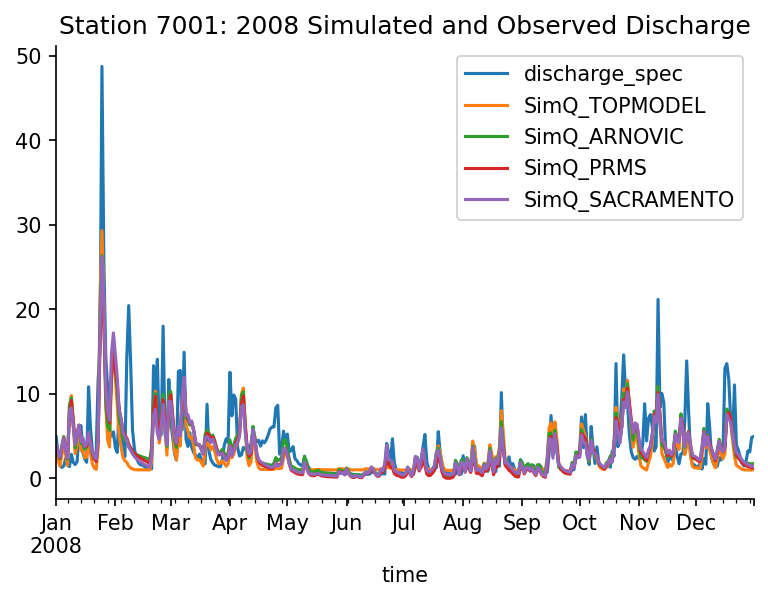

In [213]:
station_id = int(fuse_data.isel(station_id=10).station_id.values)
df.plot()
ax = plt.gca()
ax.set_title(f"Station {station_id}: 2008 Simulated and Observed Discharge")
sns.despine()

In [218]:
# fuse_data.to_netcdf(data_dir / 'RUNOFF/fuse_data.nc')

### Check on 10 random stations that the data is correct

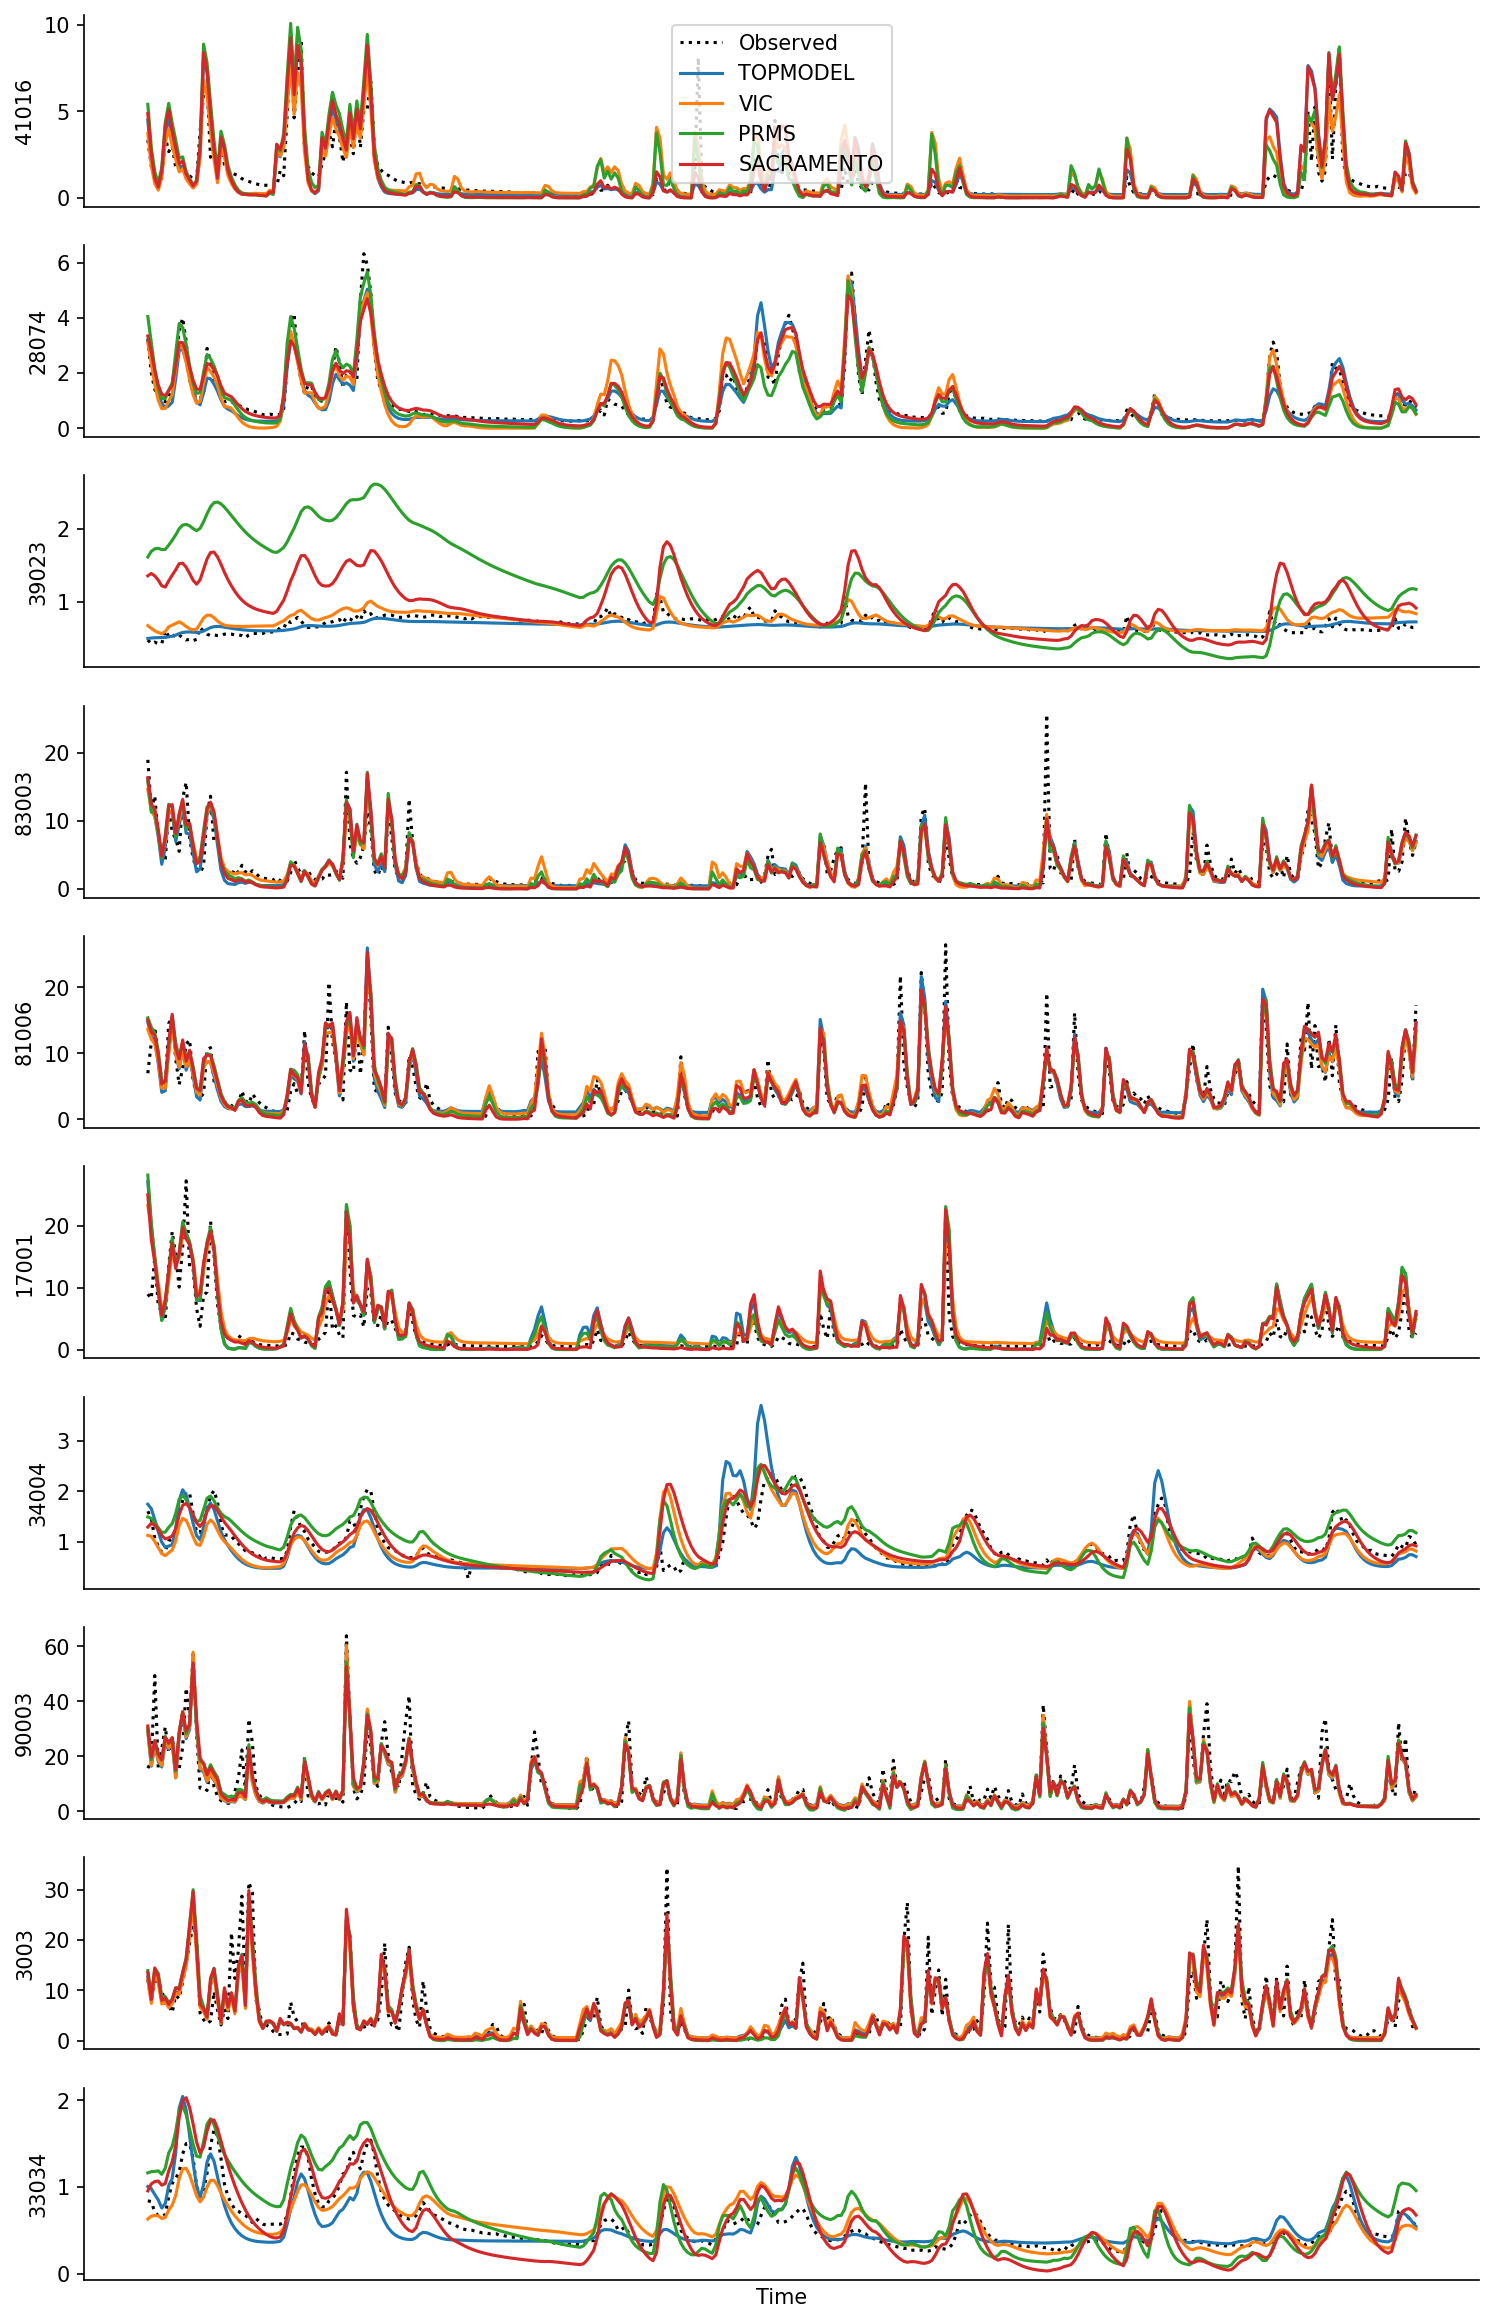

In [217]:
stations = np.random.choice(fuse_data.station_id.values, 10)
fuse_data = fuse_data.rename({'discharge_spec': 'obs'})

f, axs = plt.subplots(10, 1, figsize=(12, 2*10))
for ix, station in enumerate(stations):
    ax = axs[ix]
    df = fuse_data.sel(station_id=station, time=(fuse_data['time.year'] == 2007)).to_dataframe()
    ax.plot(np.arange(len(df)), df["obs"], color="k", ls=":", label="Observed")
    ax.plot(np.arange(len(df)), df["SimQ_TOPMODEL"], color=sns.color_palette()[0], label="TOPMODEL")
    ax.plot(np.arange(len(df)), df["SimQ_ARNOVIC"], color=sns.color_palette()[1], label="VIC")
    ax.plot(np.arange(len(df)), df["SimQ_PRMS"], color=sns.color_palette()[2], label="PRMS")
    ax.plot(np.arange(len(df)), df["SimQ_SACRAMENTO"], color=sns.color_palette()[3], label="SACRAMENTO")
    ax.set_xticks([])
    ax.set_xticklabels([""])
    ax.set_ylabel(f"{station}")
    if ix == 0:
        ax.legend()
    if ix == 9:
        ax.set_xlabel("Time")
sns.despine()

# 13 Catchments

In [77]:
from typing import (Tuple, Dict, Optional, List, Union, Any)

def remove_invalid_vals(x, y) -> Tuple[np.ndarray, np.ndarray]:
    """check for infinite or nan values
    
    Required for np.polyfit:
    https://stackoverflow.com/a/13693657/9940782
    """
    isfinite = np.isfinite(y) & np.isfinite(x)
    notnull = pd.notnull(y) & pd.notnull(x)
    
    x = x[isfinite & notnull]
    y = y[isfinite & notnull]
    
    return x, y
    

def plot_1_1_line(x: np.ndarray, ax) -> plt.Axes:
    # plot 1:1 line
    line_1_1_x = np.linspace(x.min(), x.max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line', alpha=0.5)
    return ax


def plot_scatter(x: np.ndarray, y: np.ndarray, ax, one_to_one: bool = True, **kwargs) -> plt.Axes:
    """Scatter plot of x vs. y"""
    # plot scatter
    ax.plot(x, y, 'kx', **kwargs)
    
    if one_to_one:
        # plot 1:1 line
        ax = plot_1_1_line(x, ax)

    return ax


def plot_reg_line(x: np.ndarray, y: np.ndarray, ax, auto_label: bool = True, **kwargs):
    """plot linear regression line of x vs. y"""
    # plot regression line
    x, y = remove_invalid_vals(x, y)
    m, b = np.polyfit(x, y, 1)
    reg = (m * x + b)
    if auto_label:
        label = f'Regression Line: {m:.2f}X + {b:.2f}'
        ax.plot(x, reg, label=label, **kwargs)
    else:
        ax.plot(x, reg, **kwargs)

    return ax


def plot_station_scatter(
    df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None
):
    # select station & data
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    x = d[target_var]
    y = d.preds
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    # plot scatter
    kwargs = dict(alpha=0.6, label='Data Point')
    ax = plot_scatter(x, y, ax, **kwargs)

    # plot regression line
    kwargs = dict(color = '#7bd250', ls='--')
    ax = plot_reg_line(x, y, ax=ax, **kwargs)

    # make the plot pretty
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    if 'month' in df.columns:
        df = df.drop(columns='month')
    
    # plot the station
    if plot_years is None:
        df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    else:
        (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id').plot(ax=ax)
        )
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

In [78]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [79]:
fuse_13 = fuse_data.sel(station_id=np.isin(fuse_data['station_id'], catchment_ids))

In [80]:
fuse_13

<xarray.Dataset>
Dimensions:          (station_id: 13, time: 5844)
Coordinates:
  * station_id       (station_id) int64 12002 15006 27009 ... 54057 71001 84013
  * time             (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...
    obs              (time, station_id) float64 ...

# Errors

In [81]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse, spatial_bias
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

In [82]:
obs = fuse_data["obs"].transpose("station_id", "time")
topmodel = fuse_data["SimQ_TOPMODEL"]
arnovic = fuse_data["SimQ_ARNOVIC"]
prms = fuse_data["SimQ_PRMS"]
sacramento = fuse_data["SimQ_SACRAMENTO"]

# NOTE: do we need to calculate these again when we can just use the NSE scores calculated by Lane et al directly?

In [83]:
gauge_names = static['gauge_name'].to_dataframe()
gauge_names.head()

,gauge_name
station_id,
1001,Wick at Tarroul
2001,Helmsdale at Kilphedir
2002,Brora at Bruachrobie
3003,Oykel at Easter Turnaig
4001,Conon at Moy Bridge


In [84]:
# NSE
nse2_df = performance_scores.loc[:, [("ID" in c) or ("NSE" in c) for c in performance_scores.columns]]
nse2_df = gauge_names.join(nse2_df.set_index("Gauge_ID")).rename({"gauge_name": "Name"}, axis=1)
nse2_df.columns = [["NSE" for _ in range(len(nse2_df.columns))], [c.replace("NSE_", "") for c in nse2_df.columns]]

# MSE
mse2_df = performance_scores.loc[:, [("ID" in c) or ("MSE" in c) for c in performance_scores.columns]]
mse2_df = gauge_names.join(mse2_df.set_index("Gauge_ID")).rename({"gauge_name": "Name"}, axis=1)
mse2_df.columns = [["MSE" for _ in range(len(mse2_df.columns))], [c.replace("MSE_", "") for c in mse2_df.columns]]

# Bias
bias2_df = performance_scores.loc[:, [("ID" in c) or ("Bias" in c) for c in performance_scores.columns]]
bias2_df = gauge_names.join(bias2_df.set_index("Gauge_ID")).rename({"gauge_name": "Name"}, axis=1)
bias2_df.columns = [["BIAS" for _ in range(len(bias2_df.columns))], [c.replace("Relative_Bias_", "") for c in bias2_df.columns]]

display(nse2_df.head())
display(bias2_df.head())
display(mse2_df.head())

NSE                                         
                               Name  TOPMODEL       VIC      PRMS SACRAMENTO
station_id                                                                  
1001                Wick at Tarroul  0.755836  0.764714  0.788691   0.806047
2001         Helmsdale at Kilphedir  0.638955  0.674150  0.674432   0.692287
2002           Brora at Bruachrobie  0.692957  0.687312  0.683122   0.702109
3003        Oykel at Easter Turnaig  0.796328  0.787968  0.779536   0.793024
4001            Conon at Moy Bridge  0.726878  0.818241  0.766328   0.785913

BIAS                                    \
                               Name  TOPMODEL       VIC          PRMS   
station_id                                                              
1001                Wick at Tarroul -0.000001  0.000031  1.133441e-05   
2001         Helmsdale at Kilphedir  0.000006  0.000078  1.076186e-07   
2002           Brora at Bruachrobie -0.000004  0.000034  2.067214e-07   
3003        Oykel at Easter Turnaig  0.000010 -0.001048  2.445604e-02   
4001            Conon at Moy Bridge  0.000220 -0.000004 -1.592926e-02   

                       
           SACRAMENTO  
station_id             
1001         0.000030  
2001        -0.000014  
2002         0.000005  
3003        -0.000020  
4001        -0.064909

MSE                                         
                               Name  TOPMODEL       VIC      PRMS SACRAMENTO
station_id                                                                  
1001                Wick at Tarroul  0.993700  0.957569  0.859985   0.789353
2001         Helmsdale at Kilphedir  2.152595  1.942754  1.941077   1.834621
2002           Brora at Bruachrobie  3.357516  3.419246  3.465064   3.257446
3003        Oykel at Easter Turnaig  6.886701  7.169354  7.454475   6.998388
4001            Conon at Moy Bridge  3.647056  2.427068  3.120266   2.858745

## NSE

In [85]:
top_nse = spatial_nse(obs, topmodel).rename("TOPMODEL")
vic_nse = spatial_nse(obs, arnovic).rename("VIC")
prms_nse = spatial_nse(obs, prms).rename("PRMS")
sac_nse = spatial_nse(obs, sacramento).rename("Sacramento")

In [30]:
nse = xr.merge([
    top_nse,
    vic_nse,
    prms_nse,
    sac_nse,
])
nse_df = nse.to_dataframe()
nse_df = static['gauge_name'].to_dataframe().join(nse_df).rename(columns=dict(gauge_name="Name"))
nse_df.to_csv(data_dir / 'RUNOFF/FUSE_nse_table.csv')
nse_df.columns = [["nse" for _ in range(len(nse_df.columns))], nse_df.columns]
nse_df.head()

nse                                         
                               Name  TOPMODEL       VIC      PRMS Sacramento
station_id                                                                  
1001                Wick at Tarroul  0.754303  0.766521  0.786218   0.805396
2001         Helmsdale at Kilphedir  0.655162  0.685077  0.686722   0.699972
2002           Brora at Bruachrobie  0.691850  0.681148  0.683937   0.697952
3003        Oykel at Easter Turnaig  0.806642  0.799981  0.793153   0.805893
4001            Conon at Moy Bridge  0.724438  0.818019  0.777022   0.792738

In [31]:
top_rmse = spatial_rmse(obs, topmodel).rename("TOPMODEL")
vic_rmse = spatial_rmse(obs, arnovic).rename("VIC")
prms_rmse = spatial_rmse(obs, prms).rename("PRMS")
sac_rmse = spatial_rmse(obs, sacramento).rename("Sacramento")

rmse = xr.merge([
    top_rmse,
    vic_rmse,
    prms_rmse,
    sac_rmse,
])
rmse_df = rmse.to_dataframe().drop(columns='time')
rmse_df.to_csv(data_dir / 'RUNOFF/FUSE_rmse_table.csv')
rmse_df.columns = [["rmse" for _ in range(len(rmse_df.columns))], rmse_df.columns]


In [32]:
top_r2 = spatial_r2(obs, topmodel).rename("TOPMODEL")
vic_r2 = spatial_r2(obs, arnovic).rename("VIC")
prms_r2 = spatial_r2(obs, prms).rename("PRMS")
sac_r2 = spatial_r2(obs, sacramento).rename("Sacramento")

r2 = xr.merge([
    top_r2,
    vic_r2,
    prms_r2,
    sac_r2,
])
r2_df = r2.to_dataframe().drop(columns='time')
r2_df.to_csv(data_dir / 'RUNOFF/FUSE_r2_table.csv')
r2_df.columns = [["r2" for _ in range(len(r2_df.columns))], r2_df.columns]

In [33]:
top_bias = spatial_bias(obs, topmodel).rename("TOPMODEL")
vic_bias = spatial_bias(obs, arnovic).rename("VIC")
prms_bias = spatial_bias(obs, prms).rename("PRMS")
sac_bias = spatial_bias(obs, sacramento).rename("Sacramento")

bias = xr.merge([
    top_bias,
    vic_bias,
    prms_bias,
    sac_bias,
])
bias_df = bias.to_dataframe()
bias_df.to_csv(data_dir / 'RUNOFF/FUSE_bias_table.csv')
bias_df.columns = [["bias" for _ in range(len(bias_df.columns))], bias_df.columns]

In [34]:
RECALCULATE = False

if RECALCULATE:
    fuse_errors = pd.concat([nse_df, rmse_df, r2_df, bias_df], axis=1)
else:
    fuse_errors = pd.concat([nse2_df, mse2_df, bias2_df], axis=1)
    
try:
    fuse_errors = fuse_errors.drop('time', axis=1, level=1).swaplevel(axis=1).sort_index(axis=1)
except KeyError:
    pass
if RECALCULATE:
    fuse_errors.to_csv(data_dir / 'RUNOFF/FUSE_errors_recalculated.csv')
    fuse_errors.to_pickle(data_dir / 'RUNOFF/FUSE_errors_recalculated.pkl')
else:
    fuse_errors = fuse_errors.drop(
        [("MSE", "Name"),
        ("BIAS", "Name")],
        axis=1
    )
    fuse_errors.to_csv(data_dir / 'RUNOFF/FUSE_errors_published.csv')
    fuse_errors.to_pickle(data_dir / 'RUNOFF/FUSE_errors_published.pkl')

In [35]:
fuse_errors

NSE                                           \
                                Name  TOPMODEL       VIC      PRMS SACRAMENTO   
station_id                                                                      
1001                 Wick at Tarroul  0.755836  0.764714  0.788691   0.806047   
2001          Helmsdale at Kilphedir  0.638955  0.674150  0.674432   0.692287   
2002            Brora at Bruachrobie  0.692957  0.687312  0.683122   0.702109   
3003         Oykel at Easter Turnaig  0.796328  0.787968  0.779536   0.793024   
4001             Conon at Moy Bridge  0.726878  0.818241  0.766328   0.785913   
...                              ...       ...       ...       ...        ...   
101002               Medina at Shide  0.616119  0.696603  0.554009   0.724537   
101005      Eastern Yar at Budbridge  0.638900  0.671685  0.445414   0.706599   
102001            Cefni at Bodffordd  0.728707  0.738542  0.722606   0.728517   
106001         Creed at Creed Bridge  0.812398  0.828563  0.823775   0.833594   
107001        Durkadale at Durkadale       NaN       NaN       NaN        NaN   

                 MSE                                     BIAS            \
            TOPMODEL       VIC      PRMS SACRAMENTO  TOPMODEL       VIC   
station_id                                                                
1001        0.993700  0.957569  0.859985   0.789353 -0.000001  0.000031   
2001        2.152595  1.942754  1.941077   1.834621  0.000006  0.000078   
2002        3.357516  3.419246  3.465064   3.257446 -0.000004  0.000034   
3003        6.886701  7.169354  7.454475   6.998388  0.000010 -0.001048   
4001        3.647056  2.427068  3.120266   2.858745  0.000220 -0.000004   
...              ...       ...       ...        ...       ...       ...   
101002      0.466656  0.368818  0.542160   0.334860  0.000004  0.000092   
101005      0.422756  0.384373  0.649279   0.343498  0.000068  0.000004   
102001      2.087245  2.011582  2.134188   2.088709  0.000004 -0.000132   
106001      1.973265  1.803236  1.853598   1.750316  0.000008  0.000110   
107001           NaN       NaN       NaN        NaN       NaN       NaN   

                                     
                    PRMS SACRAMENTO  
station_id                           
1001        1.133441e-05   0.000030  
2001        1.076186e-07  -0.000014  
2002        2.067214e-07   0.000005  
3003        2.445604e-02  -0.000020  
4001       -1.592926e-02  -0.064909  
...                  ...        ...  
101002     -1.064782e-04  -0.000049  
101005      1.691433e-01   0.000098  
102001      1.353198e-05  -0.000069  
106001     -3.111451e-06  -0.000024  
107001               NaN        NaN  

[671 rows x 13 columns]

### 13 stations

In [36]:
fuse_13 = fuse_errors.loc[np.isin(fuse_errors.index, catchment_ids)]
fuse_13 = fuse_13.rename(columns=dict(nse="NSE", r2="R2", rmse="RMSE", catchment_name="Name"))
fuse_13.index.name = "Station ID"
fuse_13

NSE                                           \
                               Name  TOPMODEL       VIC      PRMS SACRAMENTO   
Station ID                                                                     
12002                   Dee at Park  0.614672  0.682167  0.653526   0.675102   
15006              Tay at Ballathie  0.786324  0.863796  0.841181   0.857075   
27009               Ouse at Skelton  0.850947  0.882587  0.878732   0.897445   
27034         Ure at Kilgram Bridge  0.823744  0.830399  0.828210   0.836142   
27041       Derwent at Buttercrambe  0.765636  0.854433  0.849083   0.892766   
39001            Thames at Kingston  0.746571  0.779965  0.693976   0.881875   
39081               Ock at Abingdon  0.712582  0.746671  0.761862   0.830130   
43021            Avon at Knapp Mill  0.551778  0.910636  0.828939   0.890455   
47001           Tamar at Gunnislake  0.858407  0.887483  0.875458   0.885780   
54001             Severn at Bewdley  0.881450  0.884836  0.867898   0.919785   
54057          Severn at Haw Bridge  0.879066  0.877529  0.882947   0.924968   
71001          Ribble at Samlesbury  0.828884  0.818527  0.824346   0.835397   
84013             Clyde at Daldowie  0.849386  0.875158  0.844045   0.873136   

                 MSE                                     BIAS                \
            TOPMODEL       VIC      PRMS SACRAMENTO  TOPMODEL           VIC   
Station ID                                                                    
12002       2.147899  1.771667  1.931320   1.811047 -0.000025 -1.687790e-05   
15006       1.786023  1.138463  1.327499   1.194644 -0.000028 -1.917355e-05   
27009       0.384764  0.303089  0.313040   0.264734 -0.000021  1.002352e-05   
27034       3.056418  2.941008  2.978966   2.841425 -0.000005 -1.343954e-06   
27041       0.166662  0.103517  0.107321   0.076257 -0.000031  1.011191e-04   
39001       0.101217  0.087880  0.122223   0.047178  0.000029  1.223242e-04   
39081       0.088477  0.077983  0.073307   0.052292 -0.000004  3.749984e-04   
43021       0.362079  0.072189  0.138185   0.088491  0.000001 -8.975508e-05   
47001       1.096403  0.871257  0.964372   0.884448 -0.000010  4.299846e-05   
54001       0.198208  0.192548  0.220866   0.134115 -0.000021  5.434920e-05   
54057       0.131679  0.133353  0.127453   0.081698 -0.000015 -1.645217e-04   
71001       2.223588  2.358163  2.282559   2.138946  0.000056  1.100516e-07   
84013       0.976696  0.809572  1.011331   0.822685  0.000002 -3.513319e-05   

                                     
                    PRMS SACRAMENTO  
Station ID                           
12002       2.092838e-05   0.000020  
15006       1.043806e-04  -0.000066  
27009      -1.974864e-06  -0.000015  
27034       2.049910e-05   0.000001  
27041      -4.079770e-07  -0.000021  
39001       2.282269e-01   0.000670  
39081       1.580312e-04  -0.000036  
43021       4.586979e-05  -0.000034  
47001       2.489619e-05   0.000038  
54001       6.199083e-02   0.000068  
54057       9.352401e-05  -0.000046  
71001       9.418241e-07   0.000006  
84013      -1.926028e-06   0.000004

In [37]:
print(fuse_13.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
{} & \multicolumn{5}{l}{NSE} & \multicolumn{4}{l}{MSE} & \multicolumn{4}{l}{BIAS} \\
{} &                     Name & TOPMODEL &  VIC & PRMS & SACRAMENTO & TOPMODEL &  VIC & PRMS & SACRAMENTO & TOPMODEL &   VIC &  PRMS & SACRAMENTO \\
Station ID &                          &          &      &      &            &          &      &      &            &          &       &       &            \\
\midrule
12002      &              Dee at Park &     0.61 & 0.68 & 0.65 &       0.68 &     2.15 & 1.77 & 1.93 &       1.81 &    -0.00 & -0.00 &  0.00 &       0.00 \\
15006      &         Tay at Ballathie &     0.79 & 0.86 & 0.84 &       0.86 &     1.79 & 1.14 & 1.33 &       1.19 &    -0.00 & -0.00 &  0.00 &      -0.00 \\
27009      &          Ouse at Skelton &     0.85 & 0.88 & 0.88 &       0.90 &     0.38 & 0.30 & 0.31 &       0.26 &    -0.00 &  0.00 & -0.00 &      -0.00 \\
27034      &    Ure at Kilgram Bridge &     0.82 & 0.83 & 0.83 &       0.84 &     3.06 &

# distribution of errors

In [38]:
nse_df.columns = ["Name", "TOPMODEL", "VIC", "PRMS", "Sacramento"]
nse_df.to_csv(data_dir / "RUNOFF/FUSE_nse_all_stations.csv")

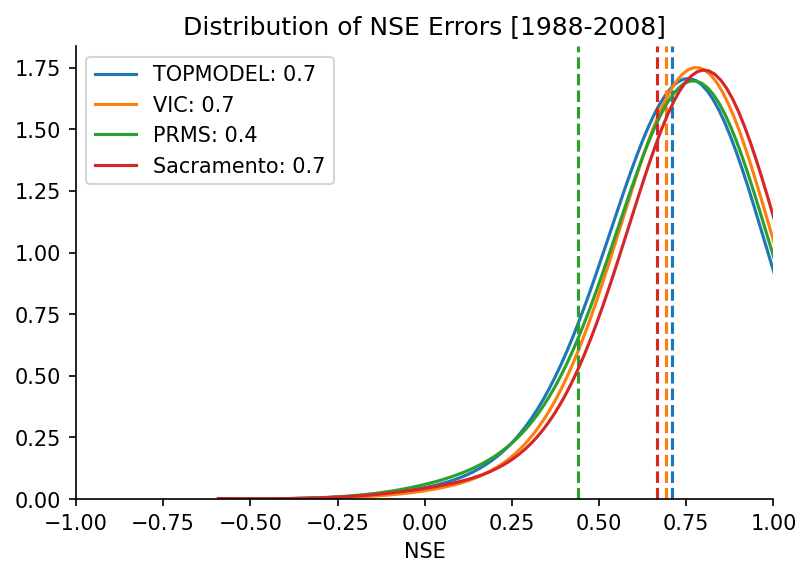

In [39]:
fig, ax = plt.subplots()
colors = sns.color_palette()

for ix, model in enumerate([c for c in nse_df.columns if c != "Name"]):
    sns.kdeplot(nse_df[model], ax=ax, label=f"{model}: {nse_df[model].mean():.1f}", bw=0.2, clip=(0, 1), color=colors[ix])
    ax.axvline(nse_df[model].mean(), ls='--', color=colors[ix])

ax.set_xlim([-1, 1])
ax.set_xlabel('NSE')

ax.set_title("Distribution of NSE Errors [1988-2008]")
sns.despine()

# Open the ML Experiments

In [190]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble

In [191]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
ealstm_preds = xr.open_dataset(data_dir / "RUNOFF/ealstm_epoch30_ensemble2/results.nc")
ealstm_preds["station_id"] = [int(sid) for sid in ealstm["station_id"]]
ealstm_preds = ealstm_preds.rename({"discharge_spec_obs": "obs", "discharge_spec_sim": "sim"})
ealstm_df = ealstm_preds.to_dataframe().reset_index()

NameError: name 'ealstm' is not defined

In [46]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

def error_func(preds_xr: xr.Dataset, error_str: str) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
    }
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d["sim"].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d["sim"].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, error_str: errors})
    
    return error

In [47]:
errors = [ 
    error_func(ealstm_preds, "nse").set_index('station_id'),
    error_func(ealstm_preds, "r2").set_index('station_id'), 
    error_func(ealstm_preds, "rmse").set_index('station_id'),
]
ealstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

errors = [ 
    error_func(lstm_preds, "nse").set_index('station_id'),
    error_func(lstm_preds, "r2").set_index('station_id'), 
    error_func(lstm_preds, "rmse").set_index('station_id'),
]
lstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

# Get Static data Table

In [48]:
hydrologic_attributes = [
    "gauge_name",
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    "baseflow_index",
    "baseflow_index_ceh",
    "hfd_mean",
    "Q5",
    "Q95",
    "high_q_freq",
    "high_q_dur",
    "low_q_freq",
    "low_q_dur",
]

rename = dict(zip(
    hydrologic_attributes,
    [
        "Name",
        "Mean Discharge (Q) ($mm^{-3} day^{-1}$)",
        "Runoff Ratio",
        "Stream elasticity",
        "Slope of the Flow-Duration-Curve",
        "Baseflow Index",
        "Baseflow Index CEH",
        "hfd_mean",
        "Q5 Discharge ($mm^{-3} day^{-1}$)",
        "Q95 Discharge ($mm^{-3} day^{-1}$)",
        "High Discharge (Q) Frequency",
        "High Discharge (Q) Duration",
        "Low Discharge (Q) Frequency",
        "Low Discharge (Q) Duration",
    ]
))

In [49]:
print(
    static[hydrologic_attributes]
    .sel(station_id=np.isin(static["station_id"], catchment_ids))
    .to_dataframe()
    .rename(columns=rename)
    .to_latex(float_format="%.2f")

)

\begin{tabular}{llrrrrrrrrrrrrr}
\toprule
{} &                     Name &  Mean Discharge (Q) (\$mm\textasciicircum \{-3\} day\textasciicircum \{-1\}\$) &  Runoff Ratio &  Stream elasticity &  Slope of the Flow-Duration-Curve &  Baseflow Index &  Baseflow Index CEH &  hfd\_mean &  Q5 Discharge (\$mm\textasciicircum \{-3\} day\textasciicircum \{-1\}\$) &  Q95 Discharge (\$mm\textasciicircum \{-3\} day\textasciicircum \{-1\}\$) &  High Discharge (Q) Frequency &  High Discharge (Q) Duration &  Low Discharge (Q) Frequency &  Low Discharge (Q) Duration \\
station\_id &                          &                                          &               &                    &                                   &                 &                     &           &                                    &                                     &                               &                              &                              &                             \\
\midrule
12002      &             

In [50]:
df = lstm_less_vars.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1)
metrics_df = lstm_df

# test_stations = ['22007', '27049', '28018', '31021', '31023', '34004', '35003', '39022', '41029', '51001', '55025', '57004', '83010']
catchment_ids = ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]

In [51]:
def get_error_df(model: str, fuse_errors: pd.DataFrame) -> pd.DataFrame:
    all_models = ["TOPMODEL", "VIC", "PRMS", "Sacramento"]
    assert model in all_models
    remove_models = [m for m in all_models if m != model]
    error_df = fuse_errors.drop(remove_models, axis=1, level=1).swaplevel(axis=1).sort_index(axis=1).droplevel(axis=1, level=0)
    rename_cols = pd.io.parsers.ParserBase({'names': error_df.columns})._maybe_dedup_names(error_df.columns)
    error_df.columns = [n if n != "nse" else "Name" for n in rename_cols]
    return error_df.rename({"nse.1": "nse"}, axis=1)


topmodel = fuse_data[["obs", "SimQ_TOPMODEL"]].to_dataframe().reset_index()
vic = fuse_data[["obs", "SimQ_ARNOVIC"]].to_dataframe().reset_index()
prms = fuse_data[["obs", "SimQ_PRMS"]].to_dataframe().reset_index()
sacramento = fuse_data[["obs", "SimQ_SACRAMENTO"]].to_dataframe().reset_index()

top_error = get_error_df("TOPMODEL", fuse_errors)
vic_error = get_error_df("VIC", fuse_errors)
prms_error = get_error_df("PRMS", fuse_errors)
sac_error = get_error_df("Sacramento", fuse_errors)

In [52]:
lstm_less_vars.head()

,station_id,time,obs,sim
0,1001,2004-01-01,9.16,10.026257
1,1001,2004-01-02,6.23,5.819096
2,1001,2004-01-03,5.60,5.267475
3,1001,2004-01-04,4.45,5.064303
4,1001,2004-01-05,4.46,5.131446


# Get the median basins etc.

In [53]:
assert (data_dir / "RUNOFF/all_nse.csv").exists()
assert (data_dir / "RUNOFF/all_bias.csv").exists()

all_nse = pd.read_csv((data_dir / "RUNOFF/all_nse.csv"))
all_bias = pd.read_csv((data_dir / "RUNOFF/all_bias.csv"))

all_nse.head()

,Station ID,Name,TOPMODEL,VIC,PRMS,Sacramento,EALSTM,LSTM,CLASSIC,JULES
0,12002,Dee at Park,0.614672,0.682167,0.653526,0.675102,0.858937,0.864020,0.55,0.51
1,15006,Tay at Ballathie,0.786324,0.863796,0.841181,0.857075,0.924273,0.943893,0.46,0.64
2,27009,Ouse at Skelton,0.850947,0.882587,0.878732,0.897445,0.883401,0.906215,0.80,0.69
3,27034,Ure at Kilgram Bridge,0.823744,0.830399,0.828210,0.836142,0.872704,0.875644,0.78,0.75
4,27041,Derwent at Buttercrambe,0.765636,0.854433,0.849083,0.892766,0.747545,0.745689,0.65,0.49


In [54]:
median = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].median()]
min_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].min()]
max_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].max()]

median_station = (median["Station ID"].values, median.Name.values)
min_station = (min_["Station ID"].values, min_.Name.values)
max_station = (max_["Station ID"].values, max_.Name.values)

pd.concat([median, min_, max_])

,Station ID,Name,TOPMODEL,VIC,PRMS,Sacramento,EALSTM,LSTM,CLASSIC,JULES
10,54057,Severn at Haw Bridge,0.879066,0.877529,0.882947,0.924968,0.827025,0.879285,0.78,0.72
6,39081,Ock at Abingdon,0.712582,0.746671,0.761862,0.830130,0.428313,0.516356,0.80,-0.21
1,15006,Tay at Ballathie,0.786324,0.863796,0.841181,0.857075,0.924273,0.943893,0.46,0.64


In [55]:
summary_stations = np.vstack([median_station, min_station, max_station]).reshape(3, 2)

# Check NSE & Bias Calculations

In [140]:
from src.analysis.evaluation import _nse_func

model = "TOPMODEL"
fuse_ds.sel(station_id=obs.station_id)[f"SimQ_{model.upper()}"]
list(fuse_ds.data_vars)

['SimQ_TOPMODEL', 'SimQ_ARNOVIC', 'SimQ_PRMS', 'SimQ_SACRAMENTO']

In [184]:
from collections import defaultdict
models = ["TOPMODEL", "PRMS", "SACRAMENTO", "ARNOVIC"]
station_ids = obs.station_id.values
output = defaultdict(dict)

for model in models:
    for sid in station_ids:
        preds = fuse_ds.sel(station_id=sid)[f"SimQ_{model.upper()}"]
        score = _nse_func(obs.sel(station_id=sid).values, preds.values)
        model_ = "VIC" if model == "ARNOVIC" else model
        output[f"NSE_{model_}"][sid] = score
    #     print(f"{sid}: {score}")

In [185]:
calc_nse = pd.DataFrame(output)

In [178]:
performance_scores.head()

,Gauge_ID,NSE_TOPMODEL,NSE_VIC,NSE_PRMS,NSE_SACRAMENTO,Relative_Bias_TOPMODEL,Relative_Bias_VIC,Relative_Bias_PRMS,Relative_Bias_SACRAMENTO,Relative_diff_std_TOPMODEL,...,Relative_diff_std_PRMS,Relative_diff_std_SACRAMENTO,Correlation_TOPMODEL,Correlation_VIC,Correlation_PRMS,Correlation_SACRAMENTO,MSE_TOPMODEL,MSE_VIC,MSE_PRMS,MSE_SACRAMENTO
0,10002,0.676705,0.760394,0.729084,0.755280,0.000140,0.000053,0.000002,0.000010,0.000004,...,0.000007,-0.000050,0.870051,0.873570,0.868442,0.887319,0.682056,0.505497,0.571552,0.516288
1,10003,0.614465,0.794624,0.751196,0.756433,-0.000215,-0.000001,0.000037,-0.000046,0.000065,...,-0.000109,0.000017,0.843056,0.913798,0.910523,0.920012,0.719625,0.383347,0.464408,0.454634
2,1001,0.755836,0.764714,0.788691,0.806047,-0.000001,0.000031,0.000011,0.000030,0.000080,...,-0.000005,-0.000004,0.882052,0.889214,0.893842,0.899833,0.993700,0.957569,0.859985,0.789353
3,101002,0.616119,0.696603,0.554009,0.724537,0.000004,0.000092,-0.000106,-0.000049,0.000153,...,0.012961,-0.000103,0.849858,0.865308,0.862584,0.874849,0.466656,0.368818,0.542160,0.334860
4,101004,0.699461,0.674037,0.658303,0.760749,-0.000208,0.000341,0.187499,0.000105,0.000087,...,-0.000030,-0.000014,0.841995,0.853849,0.849699,0.876066,0.817632,0.886800,0.929603,0.650894


In [198]:
display(nse_df.head())
display(calc_nse.head())

,Name,TOPMODEL,VIC,PRMS,Sacramento
station_id,,,,,
1001,Wick at Tarroul,0.754303,0.766521,0.786218,0.805396
2001,Helmsdale at Kilphedir,0.655162,0.685077,0.686722,0.699972
2002,Brora at Bruachrobie,0.691850,0.681148,0.683937,0.697952
3003,Oykel at Easter Turnaig,0.806642,0.799981,0.793153,0.805893
4001,Conon at Moy Bridge,0.724438,0.818019,0.777022,0.792738


,NSE_TOPMODEL,NSE_PRMS,NSE_SACRAMENTO,NSE_VIC
1001,0.755664,0.791278,0.807096,0.766464
2001,0.639042,0.674502,0.692264,0.674122
2002,0.692921,0.683213,0.702039,0.687225
3003,0.796283,0.779815,0.793164,0.787945
4001,0.727826,0.766792,0.786814,0.818456


In [186]:
calculated = calc_nse
published = performance_scores.set_index("Gauge_ID").loc[calc_nse.index, calc_nse.columns]

atol = 0.05
perc_close = np.isclose(calculated, published, atol=atol).mean()
print(f"{100*perc_close:.1f}% of Stations within {atol} Calculated vs. Published for NSE")

93.6% of Stations within 0.05 Calculated vs. Published for NSE


In [237]:
within_tolerance = pd.DataFrame(np.isclose(calculated, published, atol=atol), index=calculated.index, columns=calculated.columns)
# Basins outside of tolerance
calculated[~within_tolerance.any(axis=1)]

,NSE_TOPMODEL,NSE_PRMS,NSE_SACRAMENTO,NSE_VIC
17018,-0.283488,0.173488,0.116361,0.062608
27087,0.384313,0.445020,0.574956,0.702078
28044,0.620977,0.281182,0.172923,0.755780
29003,-0.220300,0.175950,0.340427,0.076484
33007,0.218612,0.682644,0.626308,0.770605
33032,-0.276522,-2.025839,-1.536073,0.211121
34005,0.606365,-0.086334,0.659262,0.553687
39004,-0.154492,-57.233344,-20.006912,-18.048728
39027,0.084994,-2.935885,0.210758,0.216725
39095,0.639280,-0.283309,0.705993,0.643006


In [183]:
bias = lambda sim, obs: (np.nanmean(sim) - np.nanmean(obs)) / np.nanmean(obs)
# bias = lambda sim, obs: (sim.mean() - obs.mean()) / obs.mean()

output = defaultdict(dict)

for model in models:
    for sid in station_ids:
        preds = fuse_ds.sel(station_id=sid)[f"SimQ_{model.upper()}"]
        score = bias(obs.sel(station_id=sid).values, preds.values)
        model_ = "VIC" if model == "ARNOVIC" else model
        output[f"Relative_Bias_{model_}"][sid] = score

In [181]:
# calc_bias = pd.DataFrame(output)
# display(calc_bias.head())

# display(performance_scores.set_index("Gauge_ID").loc[calc_bias.index, calc_bias.columns].head())

In [187]:
calculated = calc_bias.dropna()
published = performance_scores.set_index("Gauge_ID").loc[calculated.index, calculated.columns]

atol = 0.05
perc_close = np.isclose(calculated, published, atol=atol).mean()
print(f"{100*perc_close:.1f}% of Stations within {atol} Calculated vs. Published for Bias")

33.0% of Stations within 0.05 Calculated vs. Published for Bias


In [ ]:
from src.analysis.evaluation import _bias_func

output = defaultdict(dict)

for model in models:
    for sid in station_ids:
        preds = fuse_ds.sel(station_id=sid)[f"SimQ_{model.upper()}"]
        obs = obs.sel(station_id=sid).values
        
        score = bias(, preds.values)
        model_ = "VIC" if model == "ARNOVIC" else model
        output[f"Relative_Bias_{model_}"][sid] = score